In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil
import cv2
from scipy import ndimage
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Conv2D,MaxPool2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from google.colab import files
tf.__version__
tf.random.set_seed(123)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alaaalnissany","key":"3d781699f335971d62ea758ed3df0c70"}'}

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

for datasets from **kaggle competitions**:

In [ ]:
!kaggle competitions download -c Shai-Level-2-Training-2023
#!kaggle datasets download -d andyczhao/covidx-cxr2

100% 524M/526M [00:20<00:00, 33.5MB/s]
100% 526M/526M [00:20<00:00, 27.0MB/s]


for datasets from **kaggle Datasets**:

we copy API command for this dataset

In [ ]:
!unzip ./Shai-Level-2-Training-2023.zip -d ./covid/
#!unzip /content/covidx-cxr2.zip -d ./covidx-cxr2/

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0

    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement
        self.initial_epoch=initial_epoch
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '
        print_in_color (msgs, (244, 252, 3), (55,65,80))
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80))
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        print_in_color(msg, (0,255,0), (55,65,80))

    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count


    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans



In [ ]:
def show_image_samples(gen):
    class_dict=gen.class_indices
    class_names=list( class_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
def display_eval_metrics(e_data):
    msg='Model Metrics after Training'
    print_in_color(msg, (255,255,0), (55,65,80))
    msg='{0:^24s}{1:^24s}'.format('Metric', 'Value')
    print_in_color(msg, (255,255,0), (55,65,80))
    for key,value in e_data.items():
        print (f'{key:^24s}{value:^24.5f}')
    acc=e_data['accuracy']* 100
    return acc

In [ ]:
train_list_filenames=[]
train_list_labels=[]
dstpath='./covidx-cxr2/train'
test_df = pd.read_csv('./covidx-cxr2/test.txt', sep=" ", header=None)
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ]
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
print (test_df.head())
train_txt= open("./covidx-cxr2/train.txt","r")
train_list=train_txt.readlines()
for line in train_list:
    split=line.split(' ')
    if len(split)>4:
        fname=os.path.join(dstpath, split[2])
        label=split [3]
    else:
        fname=os.path.join(dstpath, split[1])
        label=split[2]
    train_list_filenames.append(fname)
    train_list_labels.append(label)
Ftrseries=pd.Series(train_list_filenames, name='filenames')
Ltrseries=pd.Series(train_list_labels, name='labels')
df=pd.concat([Ftrseries, Ltrseries], axis=1)
print (df.head())
balance=df['labels'].value_counts()
print (balance)



                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
                                           filenames    labels
0                 ./covidx-cxr2/train/ARDSSevere.png  negative
1  ./covidx-cxr2/train/acute-respiratory-distress...  negative
2  ./covidx-cxr2/train/acute-respiratory-distress...  negative
3  ./covidx-cxr2/train/ards-secondary-to-tiger-sn...  negative
4  ./covidx-cxr2/train/pneumocystis-pneumonia-2-P...  negative
positive    15994
negative    13992
Name: labels, dtype: int64


In [ ]:
file_count = 2158
samples = []
for category in df['labels'].unique():
    category_slice = df.query("labels == @category")
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts()) # check to see each class has 200 samples
print (len(df))

positive    2158
negative    2158
Name: labels, dtype: int64
4316


In [ ]:
tsplit=.9
train_df, valid_df=train_test_split(df, train_size=tsplit, shuffle=True, random_state=123)
height=224
width=224
channels=3
batch_size=60
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.9
train_df, valid_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df))
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
length= len(test_df) # determine test batch size and test steps such that test_batch_size X test_steps = number of test samples
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=gen.flow_from_dataframe( test_df, './covidx-cxr2/test', x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
train_steps=int(len(train_gen.labels)/batch_size)

train samples:  3884   test samples:  400  validation samples 432
Found 3884 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 432 validated image filenames belonging to 2 classes.


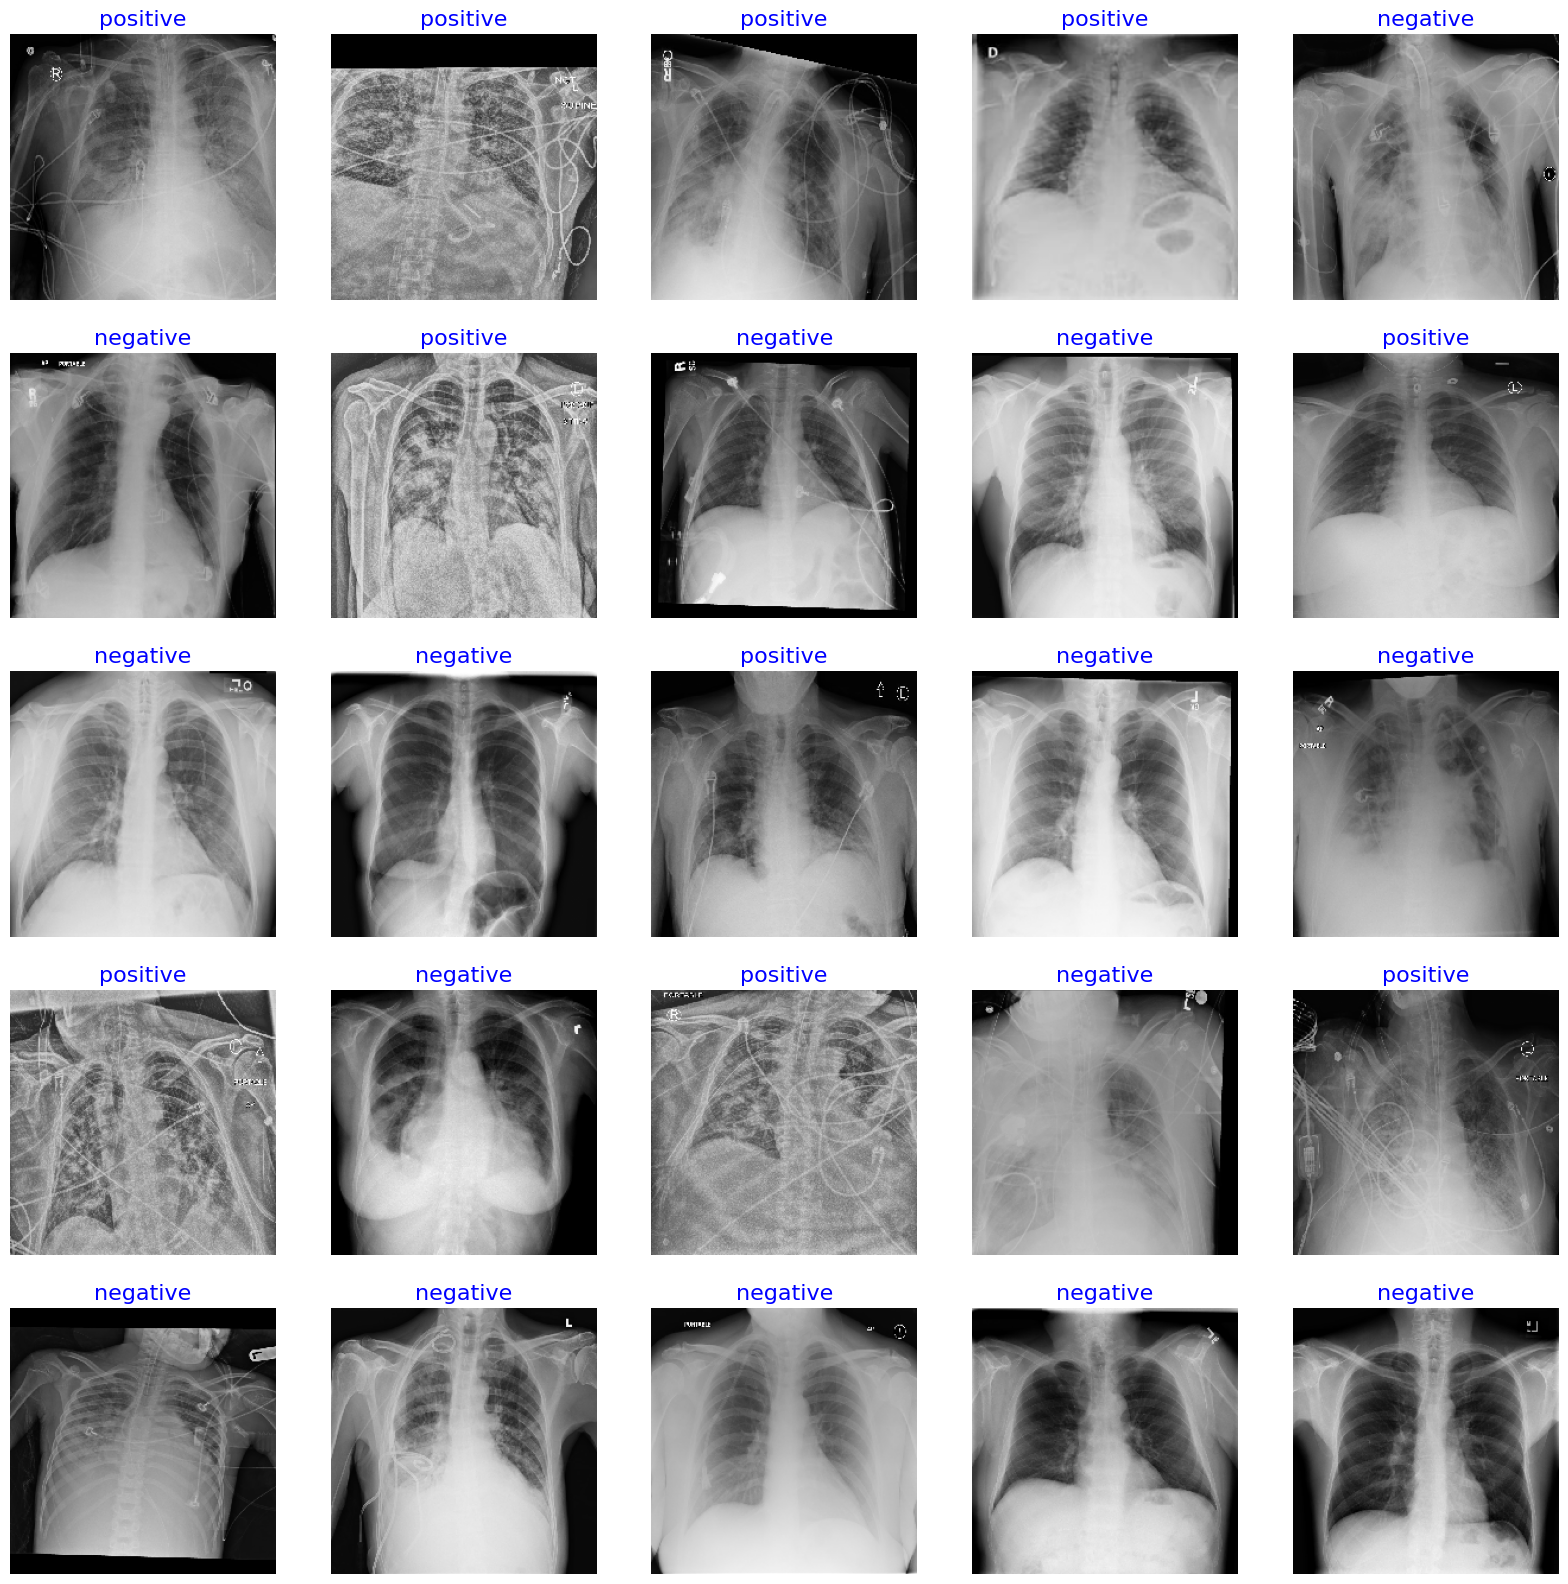

In [ ]:
show_image_samples(train_gen)

In [ ]:
class_dict=train_gen.class_indices
classes=list( class_dict.keys())
class_count=len(classes)
model_name='InceptionResNetV2'
base_model=tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
epochs =60
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model InceptionResNetV2 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /60     5.711   92.122   8.35780  49.769   0.00100  0.00100  val_loss   531.39 

 2 /60     3.089   98.532   4.39368  50.463   0.00100  0.00100  val_loss   509.59 

 3 /60     1.926   99.846   2.93179  52.315   0.00100  0.00100  val_loss   514.23 

 4 /60     1.289   99.949   2.22288  53.704   0.00100  0.00100  val_loss   507.01 

 5 /60     0.897   100.000  1.78213  56.019   0.00100  0.00100  val_loss   515.76 

 6 /60     0.644   100.000  1.45586  59.491   0.00100  0.00100  val_loss   513.81 



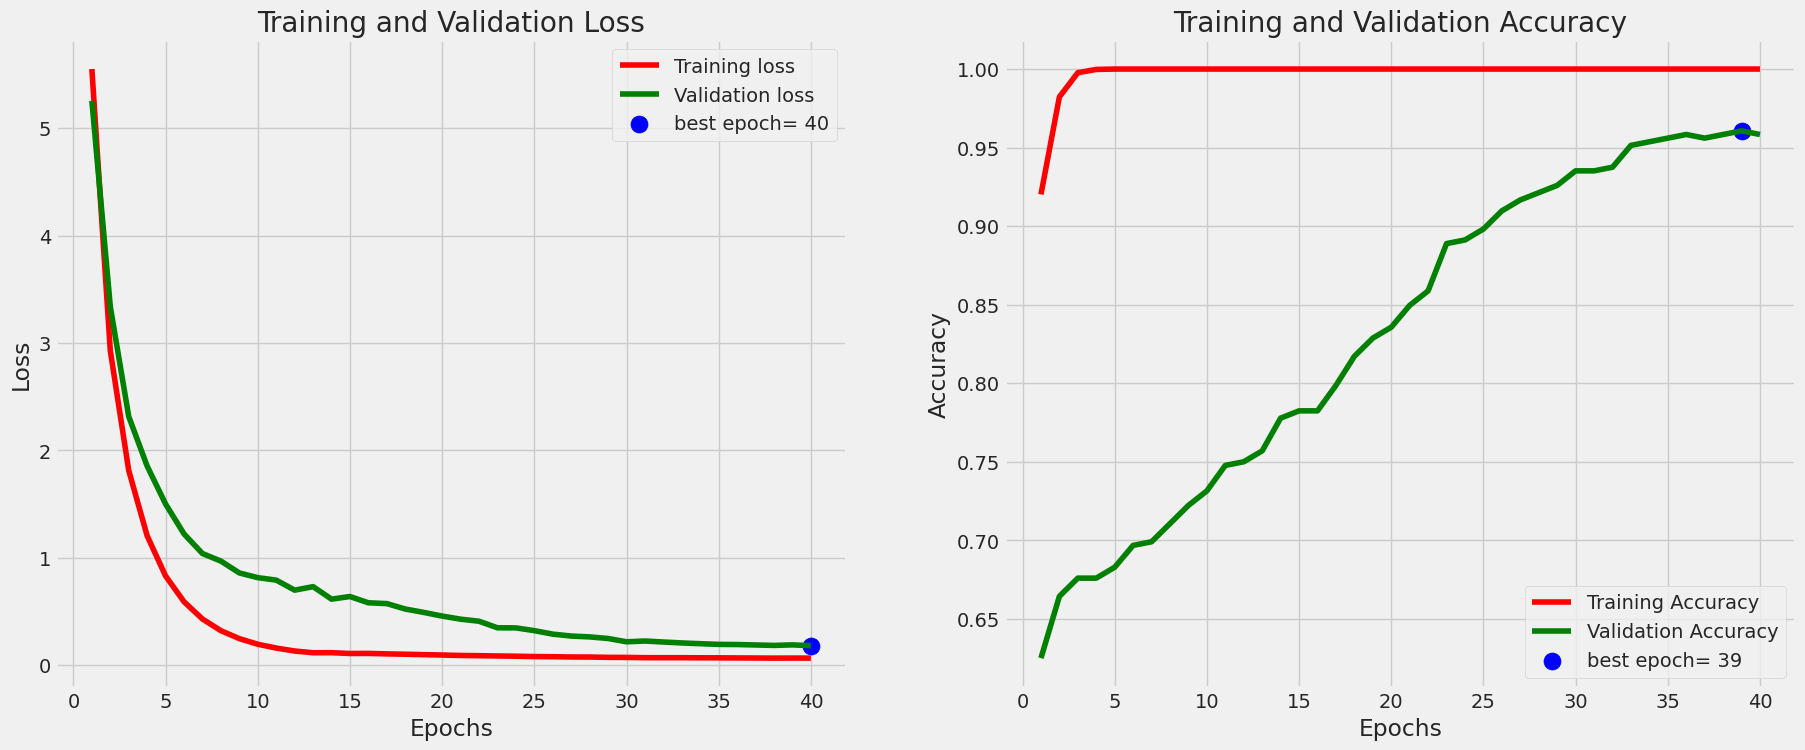

8/8 [==============================] - 20s 2s/step - loss: 0.3863 - accuracy: 0.8600
Model accuracy on test set: 86.00000143051147



In [ ]:
tr_plot(history, 0)
acc=model.evaluate(test_gen,batch_size=test_batch_size, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print_in_color(msg, (0,255,0), (55,65,80))

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')

    if len(classes)<= 30:
        # create a confusion matrix and a test report
        y_true= np.array(labels)
        y_pred=np.array(y_pred)
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        print("Classification Report:\n----------------------\n", clr)

In [ ]:
save_dir=r'./'
subject='covid'
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [ ]:
!mkdir ./aug_covid

In [ ]:
!mkdir ./aug_covid/covid ./aug_covid/normal ./aug_covid/virus

In [ ]:
# Check original images count
org_covid = r'./covid/train/covid'
org_normal = r'./covid/train/normal'
org_virus = r'./covid/train/virus'
print('COVID: ',len(os.listdir(org_covid)))
print('NORMAL: ',len(os.listdir(org_normal)))
print('VIRUS: ',len(os.listdir(org_virus)))

COVID:  295
NORMAL:  468
VIRUS:  433


In [ ]:
# Class directories
parent_dir = r'./aug_covid'
covid_dir = os.path.join(parent_dir, 'covid')# './aug_covid/covid'
normal_dir = os.path.join(parent_dir, 'normal')
virus_dir = os.path.join(parent_dir, 'virus')

In [ ]:
# Copy all data to train if not copied
if len(os.listdir(covid_dir)) == 0:
  shutil.copytree(org_covid, covid_dir, dirs_exist_ok=True)
  shutil.copytree(org_normal, normal_dir, dirs_exist_ok=True)
  shutil.copytree(org_virus, virus_dir, dirs_exist_ok=True)

In [ ]:
# Get number of required files per class
target = 500
to_move = target //10
covid_diff = target - len(os.listdir(covid_dir))
normal_diff = target - len(os.listdir(normal_dir))
virus_diff = target - len(os.listdir(virus_dir))
print(f'COVID: {covid_diff}, NORMAL: {normal_diff}, VIRUS: {virus_diff}')

COVID: 500, NORMAL: 500, VIRUS: 500


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 10,#[-10,+10]
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
img_size =224
batch_size = 32
train_generator = train_datagen.flow_from_directory("/content/covid/train/",
                                                    target_size = (img_size,img_size),
                                                    batch_size = batch_size,
                                                    color_mode="rgb",
                                                    class_mode = "categorical",
                                                    shuffle = True,
                                                    seed=42
                                                    )
val_generator = val_datagen.flow_from_directory("/content/covid/val/",
                                                target_size = (img_size,img_size),
                                                batch_size = batch_size,
                                                color_mode="rgb",
                                                class_mode = "categorical",
                                                shuffle = True,
                                                seed=42
                                                )
test_generator = test_datagen.flow_from_directory("/content/covid/test/",
                                                  target_size = (img_size,img_size),
                                                  batch_size = 1,
                                                  color_mode="rgb",
                                                  class_mode = "categorical",
                                                  shuffle = False,
                                                  seed=42)

In [ ]:
1+1

2

In [ ]:
# Use counter to stop when the difference between classes is zero
def augment_data(diff: int, dir: str) -> None:
  files = os.listdir(dir)
  for i in range(diff):
    # rotate by 5 degrees
    img_path = os.path.join(dir, files[i])#/aug_covid/d1f21sf0fs1.png
    img = cv2.imread(img_path)
    rotated = ndimage.rotate(img, 5)
    cv2.imwrite(f'{img_path[:-5]}-aug.jpg', rotated)#/aug_covid/d1f21sf0fs-aug.jpg
if covid_diff > 0 and covid_diff != (to_move*2):
  augment_data(covid_diff, covid_dir)
if normal_diff > 0 and normal_diff != (to_move*2):
  augment_data(normal_diff, normal_dir)
if virus_diff > 0 and virus_diff != (to_move*2):
  augment_data(virus_diff, virus_dir)

understanding the structure of the data:

In [ ]:
for dirpath, dirname, filename in os.walk("/content/aug_covid"):
  print(f"there are {len(dirname)} directory and {len(filename)} image in '{dirpath}'.")

there are 3 directory and 0 image in '/content/aug_covid'.
there are 0 directory and 500 image in '/content/aug_covid/virus'.
there are 0 directory and 500 image in '/content/aug_covid/normal'.
there are 0 directory and 500 image in '/content/aug_covid/covid'.


In [ ]:
data_dir = pathlib.Path('/content/aug_covid')
class_name = np.array([sorted([item.name for item in data_dir.glob("*")])])
class_name

array([['covid', 'normal', 'virus']], dtype='<U6')

In [ ]:
def veiw_image(target_dir,target_class):
  target_folder = target_dir+target_class#./aug_covid/virus or /content/aug_covid/virus
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image)

  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img,cmap = "gray")
  plt.title(target_class)
  plt.axis("off")

  return img

['43149579.jpeg']


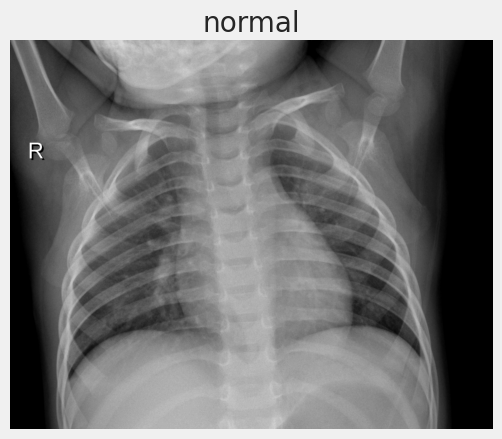

In [ ]:
img = veiw_image('/content/aug_covid/',"normal")

In [ ]:
data = []
labels = []
covid = os.listdir("/content/aug_covid/covid/")
for i in covid:
  image = cv2.imread("/content/aug_covid/covid/"+i)
  image = cv2.resize(image,(224,224))

  data.append(image)
  labels.append(0)

In [ ]:
normal = os.listdir("/content/aug_covid/normal/")
for i in normal:
  image = cv2.imread("/content/aug_covid/normal/"+i)
  image = cv2.resize(image,(300,300))

  data.append(image)
  labels.append(1)

In [ ]:
virus = os.listdir("/content/aug_covid/virus/")
for i in virus:
  image = cv2.imread("/content/aug_covid/virus/"+i)
  image = cv2.resize(image,(300,300))

  data.append(image)
  labels.append(2)

In [ ]:
data = np.array(data)/255.0
img_labels = np.array(labels)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data,img_labels,test_size=0.1,shuffle=True,random_state=123)
y_train = tf.keras.utils.to_categorical(y_train,num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=3)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224,224,3],weights="imagenet",include_top = False)
#base_model = tf.keras.applications.MobileNetV2(input_shape=[224,224,3],weights="/content/InceptionResNetV2-covid-86.00.h5",include_top = False)
#base_model = tf.keras.applications.DenseNet121 (input_shape=[224,224,3],weights="imagenet",include_top = False)
for layer in base_model.layers:
  layer.trainable= False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = Flatten()(base_model.output)
model = Dense(units= 1024,activation="relu")(model)
model = Dense(units= 512,activation="relu")(model)
model = Dense(units= 256,activation="relu")(model)

prediction_layer = Dense(units= 3,activation="softmax")(model)

In [ ]:
model = tf.keras.Model(inputs= base_model.input, outputs = prediction_layer)
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=["accuracy"])

EarlyStopping: It stops the training if the model doesn’t get better results after some epochs.

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

ReduceLROnPlateau It reduces the rate of learning (LR) if the model doesn’t get better.

In [ ]:
rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=3,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

In [ ]:
model.summary()

In [ ]:
model.fit(X_train,y_train,validation_split=0.3,epochs=15,batch_size=32,callbacks=[EarlyStopping,rlr])

Text(0.5, 1.0, 'Training and Validation Accuracy')

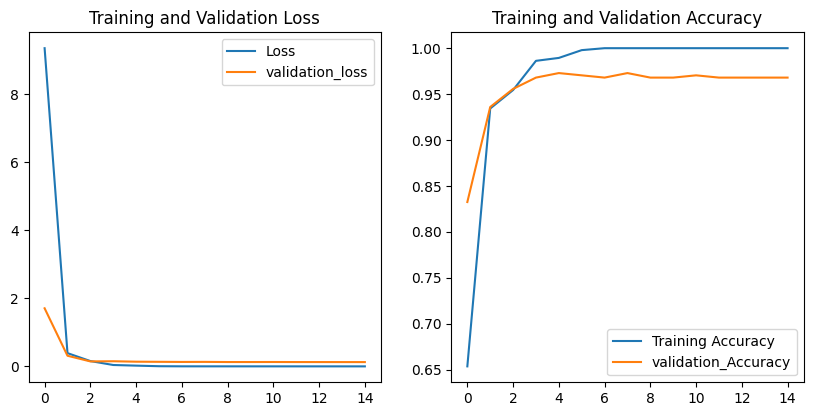

In [ ]:
loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"],label="Loss")
plt.plot(loss["val_loss"],label="validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss["accuracy"],label="Training Accuracy")
plt.plot(loss["val_accuracy"],label="validation_Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

In [ ]:
predictions = model.predict(X_test)#[0.2 0.1 0.7]

y_pred = np.argmax(predictions,axis=1)#2
y_test_new = np.argmax(y_test,axis=1)#y_test := [0 0 1] -> y_test_new=2

5/5 [==============================] - 2s 104ms/step


In [ ]:
print(classification_report(y_test_new,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       0.94      0.94      0.94        54
           2       0.94      0.94      0.94        48

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test_new,y_pred),columns=["covid","normal","virus"],index = ["covid","normal","virus"])

,covid,normal,virus
covid,48,0,0
normal,0,51,3
virus,0,3,45


In [ ]:
test_data = []
file_names = []
test_files = os.listdir("/content/covid/test/")
for i in test_files:
  image = cv2.imread("/content/covid/test/"+i)
  image = cv2.resize(image,(224,224))

  test_data.append(image)
  file_names.append(i)
test_data = np.array(test_data)/255.0

In [ ]:
test_predictions = model.predict(test_data)

y_test_pred = np.argmax(test_predictions,axis=1)

17/17 [==============================] - 2s 153ms/step


In [ ]:
df = pd.DataFrame (file_names, columns = ['Image'])
df["Label"] = y_test_pred

Label = {0:"covid",1:"normal",2:"virus"}
df["Label"] = df["Label"].apply(lambda i: Label[i])

In [ ]:
df.to_csv('test4.csv',index=False)